# como analisar modelos de classificação?

1. funções que analisam as principais métricas: F1, acurácia, precision, recall

a.tabela;
b.gráfico relacionando métricas e ponto de corte;
c.volume na base teste se eu cortar naquele ponto;
d.comparação na treino e teste dessas métricas;



2. Analisar overfitting?
- validacao cruzada treino e teste;

3. balanceamento da base

In [52]:
import pandas as pd
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC, LinearSVR
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import make_scorer, f1_score, fbeta_score, roc_auc_score, auc, roc_curve, precision_score, recall_score, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut
from sklearn.neighbors import DistanceMetric

from scipy import stats

from time import time

In [53]:
def split_train_test_data (data, name_target, test_size, random_state):
    
    X_all = data.drop([name_target], axis = 1)
    y_all = data[name_target]

    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = test_size ,random_state = random_state)

    print "Training set has {} samples and {} features.".format(X_train.shape[0], X_train.shape[1])
    print "Testing set has {} samples and {} features.".format(X_test.shape[0], X_test.shape[1])
    
    X_train.reset_index(drop=True, inplace = True)
    X_test.reset_index(drop=True, inplace = True)
    y_train.reset_index(drop=True, inplace = True)
    y_test.reset_index(drop=True, inplace = True)
    
    return X_train, X_test, y_train, y_test

def add_missing_dummy_columns (new_data, train_columns):
    missing_cols = set(train_columns) - set(new_data.columns)
    for c in missing_cols:
        new_data[c] = 0

def fix_columns (new_data, train_columns):
    add_missing_dummy_columns(new_data, train_columns)
    assert(set(train_columns) - set(new_data.columns) == set())
    extra_cols = set(new_data.columns) - set(train_columns)
    if extra_cols:
        print('columns extra', extra_cols)
    new_data = new_data[train_columns]
    return new_data

def grid_search_model (x, y, clf, parameters, scorer, cv, verbose):
    grid_obj = GridSearchCV(clf, parameters, scoring = scorer, cv =  cv, verbose= verbose)
    start = time()
    grid_fit = grid_obj.fit(x, y)
    end = time()
    print "Best score:" , grid_fit.best_score_
    print "Best parameters:" , grid_fit.best_params_
    print "Find best parameterers in {:.4f} seconds.".format(end - start) 
    return grid_fit, grid_fit.best_estimator_



def metrics_output (y_true, y_pred, y_prob1, y_prob0):
    
 
    m = { 
        'auc' : [roc_auc_score(y_true, y_prob1)],
        'f1' : [f1_score (y_true, y_pred)],
        'precision' :[ precision_score (y_true, y_pred)],
        'recall' :[ recall_score(y_true, y_pred)],
        'accuracy': [accuracy_score(y_true, y_pred)],
      
    }
    print(pd.DataFrame(m))
    print '\n'
    print(classification_report (y_true, y_pred))
    print '\n'
    print 'Matriz de confusão:'
    print (pd.DataFrame(confusion_matrix (y_true, y_pred)))

    
def model_classif_holdout (clf, X_train, y_train, X_test, y_test, metrics):
    
    clf2 = clf.fit(X_train, y_train)
       
    pred_train = clf2.predict(X_train)
    pred_test = clf2.predict(X_test)

    prob_train = clf2.predict_proba(X_train)
    prob_test = clf2.predict_proba(X_test)

    prob1_train = pd.DataFrame(prob_train).iloc[:,1]
    prob1_test = pd.DataFrame(prob_test).iloc[:,1]
    
    prob0_train = pd.DataFrame(prob_train).iloc[:,0]
    prob0_test = pd.DataFrame(prob_test).iloc[:,0]
    
    train_results = pd.concat([y_train, prob1_train], axis = 1)
    test_results = pd.concat([y_test, prob1_test], axis = 1)
    train_results.columns = ['y_train', 'prob1']
    test_results.columns = ['y_test', 'prob1']
    
    first_metric = True
    
    for metric in metrics:
            name_metric = metric.__name__
            
            if metric == roc_auc_score:
                m_tr = metric(y_train, prob1_train)
                m_te = metric(y_test, prob1_test)

            else:
                m_tr = metric(y_train, pred_train)
                m_te = metric(y_test, pred_test)
            
            m_tr_te = {
                '1.Treino': [m_tr],
                '2.Teste' : [m_te]
            }
            
            resultados_aux = pd.DataFrame(m_tr_te, index = [str(name_metric)])
            #print(resultados_aux)
            if first_metric == True:
                results_folds = resultados_aux
                first_metric = False
            else:
                results_folds = pd.concat([results_folds, resultados_aux], axis = 0)    
    
    train_prob1_True1 = train_results[train_results.y_train == 1][['prob1']]
    train_prob1_True0 = train_results[train_results.y_train == 0][['prob1']]
    
    test_prob1_True1 = test_results[test_results.y_test == 1][['prob1']]
    test_prob1_True0 = test_results[test_results.y_test == 0][['prob1']]
    
    
    m_tr_te_ks = {
                '1.Treino': [stats.ks_2samp(train_prob1_True1.prob1, train_prob1_True0.prob1).statistic],
                '2.Teste' : [stats.ks_2samp(test_prob1_True1.prob1, test_prob1_True0.prob1).statistic]
    }
    
    
    resultados_aux = pd.DataFrame(m_tr_te_ks, index = ['KS'])
    results_folds = pd.concat([results_folds, resultados_aux], axis = 0)    
    
    
    return results_folds

def model_classif_cv (model, X, y, cv, metrics):

    first = True

    for train_index, test_index in cv.split(X):
        #print(train_index)
        model2 = model.fit(X.iloc[train_index],y[train_index])
        
        pred_train = model2.predict(X.iloc[train_index])
        pred_test = model2.predict(X.iloc[test_index])
        
        prob_train = model2.predict_proba(X.iloc[train_index])
        prob_test = model2.predict_proba(X.iloc[test_index])

        prob1_train = pd.DataFrame(prob_train).iloc[:,1]
        prob1_test = pd.DataFrame(prob_test).iloc[:,1]

        prob0_train = pd.DataFrame(prob_train).iloc[:,0]
        prob0_test = pd.DataFrame(prob_test).iloc[:,0]
        
        y_train = y[train_index]
        y_test = y[test_index]
        
        train_results = pd.concat([y_train.reset_index(drop=True), prob1_train], axis = 1)
        test_results = pd.concat([y_test.reset_index(drop=True), prob1_test], axis = 1)
        train_results.columns = ['y_train', 'prob1']
        test_results.columns = ['y_test', 'prob1']
            
        first_metric = True
        for metric in metrics:
            name_metric = metric.__name__
            
            if metric == roc_auc_score:
                m_tr = metric(y_train, prob1_train)
                m_te = metric(y_test, prob1_test)
                
            else:
                m_tr = metric(y_train, pred_train)
                m_te = metric(y_test, pred_test)
            
            m_tr_te = {
                str(name_metric) +'- 1.Treino': [m_tr],
                str(name_metric) +'- 2.Teste' : [m_te]
            }
            resultados_aux = pd.DataFrame(m_tr_te)
            
            if first_metric == True:
                results_folds = resultados_aux
                first_metric = False
            else:
                results_folds = pd.concat([results_folds, resultados_aux], axis = 1)    
                
        train_prob1_True1 = train_results[train_results.y_train == 1][['prob1']]
        train_prob1_True0 = train_results[train_results.y_train == 0][['prob1']]
        
        test_prob1_True1 = test_results[test_results.y_test == 1][['prob1']]
        test_prob1_True0 = test_results[test_results.y_test == 0][['prob1']]
        
        m_tr_te_ks = {
                    'ks - 1.Treino': [stats.ks_2samp(train_prob1_True1.prob1, train_prob1_True0.prob1).statistic],
                    'ks - 2.Teste' : [stats.ks_2samp(test_prob1_True1.prob1, test_prob1_True0.prob1).statistic]
        }  
                       
        resultados_aux = pd.DataFrame(m_tr_te_ks)
        results_folds = pd.concat([results_folds, resultados_aux], axis = 1)    
    
        if first == True:
            results = results_folds
            first = False
        else:
            results = pd.concat([results, results_folds], axis = 0)    

    results.index = range(cv.get_n_splits(X))
    results_mean = np.transpose(pd.DataFrame(results.mean(), columns=['mean']))
    results = pd.concat([results, results_mean], axis = 0)

    return results


def tabela_percentis_recall_precision (data, name_prob1 , name_true, quantiles):
    data.sort_values(by = name_prob1, inplace=True, ascending=False)
    data.reset_index(inplace=True, drop=True)
    first=True
    for i, q in enumerate(quantiles):
        tam1 = data.shape[0]*q
        #print ('tam =', tam, 'q = ', q)
        tam1  = round(tam1)
        tam0 = data.shape[0] - tam1
        pred = np.concatenate((np.repeat(1,tam1), np.repeat(0,tam0)), axis =0)

        #print (data2[name_true])
        recall = recall_score(data[name_true], pred)*100
        precision = precision_score(data[name_true], pred)*100
        f1 = f1_score(data[name_true], pred)*100
        accuracy = accuracy_score(data[name_true], pred)*100
        info = {
            'a. percentil' : q,
            'b. quantidade' : tam1,
            'c. ponto de corte' : min(data[name_prob1]),
            'd. recall' : "%.1f" % recall,
            'e. precision': "%.1f" % precision,
            'f. F1': "%.1f" % f1,
            'g. accuracy' : "%.1f" % accuracy
        }
        resultados_aux = pd.DataFrame(info, index = [str(i)])
                #print(resultados_aux)
        if first == True:
            results = resultados_aux
            first = False
        else:
            results = pd.concat([results, resultados_aux], axis = 0)    

    results=results.astype(float)
    return results
    
def plot_roc_curve (y_true, prob1):
    fpr, tpr, _ = roc_curve(y_true, prob1)
    auc = roc_auc_score(y_true, prob1)
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [54]:
def information_data (data):
       
    len_array = []
    for var in data.columns:
        current_len  = len(data[var].unique())
        len_array.append(current_len)

    missing = pd.DataFrame(np.array(data.isnull().sum()), columns = ['missing'])
    p_missing = missing / data.shape[0]
    types = pd.DataFrame( np.array(data.dtypes), columns=['type'])

    qtd = pd.concat([pd.DataFrame(data.columns), types.type, missing.missing, pd.DataFrame(p_missing),  pd.DataFrame(len_array)], axis = 1)
    qtd.columns = ['var', 'type', '# missing','% missing', '# unique values']
    
    print 'Data with', data.shape[0], 'samples and ', data.shape[1], 'features'
    print '\n'
    print 'Data with', qtd[qtd['# missing'] > 0].shape[0], 'columns with missings'
    print '\n'
    
    return qtd


aplicação na base do titanic

In [55]:
path = "C:\\Users\\rhais\\Documents\\Rhaissa\\Estudos\\Kaggle\\Kaggle-Competitions\\titanic\\originais\\"

In [56]:
#Attribute Information: (classes: edible=e, poisonous=p)

In [57]:
data = pd.read_csv('mushrooms.csv')

data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [58]:
data['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

In [59]:
def class_1 (x):
    if x == 'e':
        return 0
    else:
        return 1
data['class_'] = data['class'].apply(class_1)

In [60]:
pd.crosstab(data['class'], data['class_'])

class_,0,1
class,,
e,4208,0
p,0,3916


In [61]:
data.drop('class', inplace=True, axis = 1)

In [62]:
information_data(data)

Data with 8124 samples and  23 features


Data with 0 columns with missings




,var,type,# missing,% missing,# unique values
0,cap-shape,object,0,0.0,6
1,cap-surface,object,0,0.0,4
2,cap-color,object,0,0.0,10
3,bruises,object,0,0.0,2
4,odor,object,0,0.0,9
5,gill-attachment,object,0,0.0,2
6,gill-spacing,object,0,0.0,2
7,gill-size,object,0,0.0,2
8,gill-color,object,0,0.0,12
9,stalk-shape,object,0,0.0,2


In [63]:
X_train, X_test, y_train, y_test = split_train_test_data(data, 'class_', 0.2,1)

Training set has 6499 samples and 22 features.
Testing set has 1625 samples and 22 features.


In [64]:
y_train.value_counts()

0    3388
1    3111
Name: class_, dtype: int64

#### Tratamento na base treino

In [65]:
X_train2=pd.get_dummies(X_train)

In [66]:
def nearZeroVariance (v, freqCut, uniqueCut = 0.10):
    if len (v.value_counts()) == 1:
        return True
    mostFrequent = v.value_counts()[v.value_counts().keys()[0]]
    secondMostFrequent = v.value_counts()[v.value_counts().keys()[1]]
    if mostFrequent / secondMostFrequent >= freqCut and len (v.value_counts()) / len (v) <= uniqueCut:
            return True
    return False

def apply_NZV (data, freqCut):
    array_nzv = []
    for i in data.columns:
        nzv = nearZeroVariance (data[i],freqCut = freqCut, uniqueCut = 0.005)
        array_nzv.append(nzv)
        #print(i, nzv)
    #print array_nzv
   
    nzv_df = pd.DataFrame(array_nzv, index= data.columns, columns = ['nzv'])
    true_nzv = nzv_df[nzv_df['nzv'] == True]
    data_clean = data.drop(true_nzv.index, axis = 1)
    print ("colunas excluidas", true_nzv.index)
    print "Dataframe reduzido de %d para %d" % (data.shape[1], data_clean.shape[1])
    return true_nzv.index, data_clean


In [67]:
array_nzv, X_train3 = apply_NZV(X_train2, 95/5)

('colunas excluidas', Index([u'cap-shape_c', u'cap-shape_s', u'cap-surface_g', u'cap-color_b',
       u'cap-color_c', u'cap-color_p', u'cap-color_r', u'cap-color_u',
       u'odor_a', u'odor_c', u'odor_l', u'odor_m', u'odor_p',
       u'gill-attachment_a', u'gill-attachment_f', u'gill-color_e',
       u'gill-color_o', u'gill-color_r', u'gill-color_y', u'stalk-root_r',
       u'stalk-surface-above-ring_y', u'stalk-surface-below-ring_y',
       u'stalk-color-above-ring_c', u'stalk-color-above-ring_e',
       u'stalk-color-above-ring_o', u'stalk-color-above-ring_y',
       u'stalk-color-below-ring_c', u'stalk-color-below-ring_e',
       u'stalk-color-below-ring_o', u'stalk-color-below-ring_y',
       u'veil-type_p', u'veil-color_n', u'veil-color_o', u'veil-color_w',
       u'veil-color_y', u'ring-number_n', u'ring-type_f', u'ring-type_n',
       u'spore-print-color_b', u'spore-print-color_o', u'spore-print-color_r',
       u'spore-print-color_u', u'spore-print-color_y', u'population_a',
 

#### Aplicando modelo

In [68]:
cv_kfold = KFold(6, shuffle=True, random_state=12)
clf = DecisionTreeClassifier()
parameters = {
    #'n_estimators' : [100],
    'min_samples_leaf': [0.05, 0.1, 0.3]
}
grid, model = grid_search_model(X_train3, y_train, clf, parameters, 'roc_auc', cv_kfold, 3 )
model

Fitting 6 folds for each of 3 candidates, totalling 18 fits
[CV] min_samples_leaf=0.05 ...........................................
[CV] ............ min_samples_leaf=0.05, score=0.986703, total=   0.0s
[CV] min_samples_leaf=0.05 ...........................................
[CV] ............ min_samples_leaf=0.05, score=0.986393, total=   0.0s
[CV] min_samples_leaf=0.05 ...........................................
[CV] ............ min_samples_leaf=0.05, score=0.986929, total=   0.0s
[CV] min_samples_leaf=0.05 ...........................................
[CV] ............ min_samples_leaf=0.05, score=0.986776, total=   0.0s
[CV] min_samples_leaf=0.05 ...........................................
[CV] ............ min_samples_leaf=0.05, score=0.985519, total=   0.0s
[CV] min_samples_leaf=0.05 ...........................................
[CV] ............ min_samples_leaf=0.05, score=0.988656, total=   0.0s
[CV] min_samples_leaf=0.1 ............................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ............. min_samples_leaf=0.1, score=0.979521, total=   0.0s
[CV] min_samples_leaf=0.1 ............................................
[CV] ............. min_samples_leaf=0.1, score=0.979953, total=   0.0s
[CV] min_samples_leaf=0.1 ............................................
[CV] ............. min_samples_leaf=0.1, score=0.979357, total=   0.0s
[CV] min_samples_leaf=0.1 ............................................
[CV] ............. min_samples_leaf=0.1, score=0.976243, total=   0.0s
[CV] min_samples_leaf=0.1 ............................................
[CV] ............. min_samples_leaf=0.1, score=0.976467, total=   0.0s
[CV] min_samples_leaf=0.3 ............................................
[CV] ............. min_samples_leaf=0.3, score=0.894213, total=   0.0s
[CV] min_samples_leaf=0.3 ............................................
[CV] ............. min_samples_leaf=0.3, score=0.897770, total=   0.0s
[CV] min_samples_leaf=0.3 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.4s finished


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.05,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

# CRIAR UMA FUNCAO PARA PLOTAR CV

In [69]:
tab = model_classif_cv(model, X_train3, y_train, cv_kfold, [roc_auc_score])
tab.columns = ['Treino', 'Teste', 'KS-Treino', 'KS-Teste']
tab

,Treino,Teste,KS-Treino,KS-Teste
0,0.987234,0.986703,0.891341,0.897570
1,0.987290,0.986393,0.893276,0.888157
2,0.987139,0.986929,0.890212,0.903415
3,0.987988,0.986776,0.894049,0.884461
4,0.987334,0.985519,0.894143,0.883972
5,0.986855,0.988656,0.891472,0.897350
mean,0.987307,0.986829,0.892416,0.892488


In [70]:
# Comparação da AUC em particoes de treino e teste!

C:\Users\rhais\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


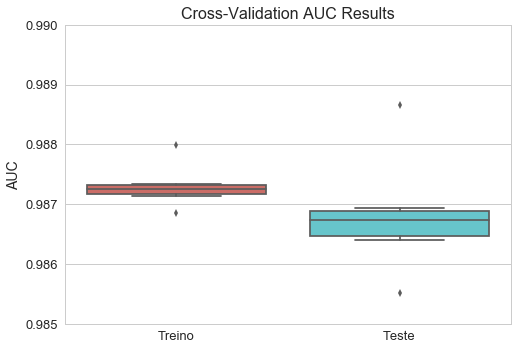

In [71]:
bplot = sns.boxplot(data=tab.ix[0:6,0:2], palette='hls')
bplot.axes.set_title("Cross-Validation AUC Results",
                    fontsize=16)
bplot.set_ylim(0.985,0.99)
bplot.set_ylabel("AUC",
                fontsize=14)
bplot.tick_params(labelsize=13)


#### Aplicação na base teste

In [72]:
X_test2 = pd.get_dummies(X_test)
X_test3 = fix_columns(X_test2, X_train3.columns)
X_test3.columns

('columns extra', set(['stalk-color-below-ring_o', 'veil-color_o', 'veil-color_y', 'spore-print-color_o', 'veil-color_n', 'cap-color_p', 'cap-color_r', 'spore-print-color_b', 'stalk-color-below-ring_c', 'cap-color_u', 'spore-print-color_y', 'ring-type_n', 'stalk-surface-above-ring_y', 'stalk-color-below-ring_y', 'veil-color_w', 'cap-color_b', 'cap-color_c', 'ring-type_f', 'stalk-root_r', 'habitat_m', 'gill-color_y', 'gill-attachment_a', 'gill-attachment_f', 'habitat_u', 'odor_p', 'stalk-color-above-ring_y', 'habitat_w', 'stalk-color-above-ring_c', 'odor_m', 'odor_l', 'stalk-color-above-ring_e', 'odor_a', 'gill-color_o', 'odor_c', 'stalk-color-above-ring_o', 'stalk-color-below-ring_e', 'gill-color_e', 'veil-type_p', 'cap-surface_g', 'spore-print-color_r', 'population_a', 'ring-number_n', 'population_c', 'stalk-surface-below-ring_y', 'spore-print-color_u', 'cap-shape_c', 'gill-color_r', 'cap-shape_s']))


Index([u'cap-shape_b', u'cap-shape_f', u'cap-shape_k', u'cap-shape_x',
       u'cap-surface_f', u'cap-surface_s', u'cap-surface_y', u'cap-color_e',
       u'cap-color_g', u'cap-color_n', u'cap-color_w', u'cap-color_y',
       u'bruises_f', u'bruises_t', u'odor_f', u'odor_n', u'odor_s', u'odor_y',
       u'gill-spacing_c', u'gill-spacing_w', u'gill-size_b', u'gill-size_n',
       u'gill-color_b', u'gill-color_g', u'gill-color_h', u'gill-color_k',
       u'gill-color_n', u'gill-color_p', u'gill-color_u', u'gill-color_w',
       u'stalk-shape_e', u'stalk-shape_t', u'stalk-root_?', u'stalk-root_b',
       u'stalk-root_c', u'stalk-root_e', u'stalk-surface-above-ring_f',
       u'stalk-surface-above-ring_k', u'stalk-surface-above-ring_s',
       u'stalk-surface-below-ring_f', u'stalk-surface-below-ring_k',
       u'stalk-surface-below-ring_s', u'stalk-color-above-ring_b',
       u'stalk-color-above-ring_g', u'stalk-color-above-ring_n',
       u'stalk-color-above-ring_p', u'stalk-color-above-


## ------------------------------------------------------------

# Métricas de avaliação - Quanto a teste se diferencia do treino em diversos pontos de corte

Na base treino

In [73]:
prob_train = pd.DataFrame(model.predict_proba(X_train3)[:,1], columns=['prob1'])
prob_test = pd.DataFrame(model.predict_proba(X_test3)[:,1], columns=['prob1'])
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)
full_table_train = pd.concat([X_train3, y_train_df, prob_train], axis=1)
full_table_test = pd.concat([X_test3, y_test_df, prob_test], axis = 1)

In [74]:
full_table_train.head()

,cap-shape_b,cap-shape_f,cap-shape_k,cap-shape_x,cap-surface_f,cap-surface_s,cap-surface_y,cap-color_e,cap-color_g,cap-color_n,...,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_p,class_,prob1
0,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0.0
1,0,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0.0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,1,1.0
3,0,0,0,1,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,1,1.0
4,0,0,0,1,1,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0.0


In [75]:
tab1 = tabela_percentis_recall_precision(full_table_train,'prob1', 'class_',quantiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
tab1

,a. percentil,b. quantidade,c. ponto de corte,d. recall,e. precision,f. F1,g. accuracy
0,0.1,650.0,0.0,20.9,100.0,34.6,62.1
1,0.2,1300.0,0.0,41.8,100.0,58.9,72.1
2,0.3,1950.0,0.0,62.7,100.0,77.1,82.1
3,0.4,2600.0,0.0,82.9,99.2,90.3,91.5
4,0.5,3250.0,0.0,96.3,92.2,94.2,94.3
5,0.6,3899.0,0.0,98.8,78.8,87.7,86.7
6,0.7,4549.0,0.0,100.0,68.4,81.2,77.9
7,0.8,5199.0,0.0,100.0,59.8,74.9,67.9
8,0.9,5849.0,0.0,100.0,53.2,69.4,57.9


In [76]:
tab2 = tabela_percentis_recall_precision(full_table_test,'prob1', 'class_',quantiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
tab2

,a. percentil,b. quantidade,c. ponto de corte,d. recall,e. precision,f. F1,g. accuracy
0,0.1,163.0,0.0,20.2,100.0,33.7,60.5
1,0.2,325.0,0.0,40.4,100.0,57.5,70.5
2,0.3,488.0,0.0,60.6,100.0,75.5,80.5
3,0.4,650.0,0.0,80.7,100.0,89.3,90.5
4,0.5,813.0,0.0,94.7,93.7,94.2,94.2
5,0.6,975.0,0.0,99.0,81.7,89.6,88.6
6,0.7,1138.0,0.0,100.0,70.7,82.9,79.5
7,0.8,1300.0,0.0,100.0,61.9,76.5,69.5
8,0.9,1463.0,0.0,100.0,55.0,71.0,59.5


In [77]:
tab2.dtypes

a. percentil         float64
b. quantidade        float64
c. ponto de corte    float64
d. recall            float64
e. precision         float64
f. F1                float64
g. accuracy          float64
dtype: object

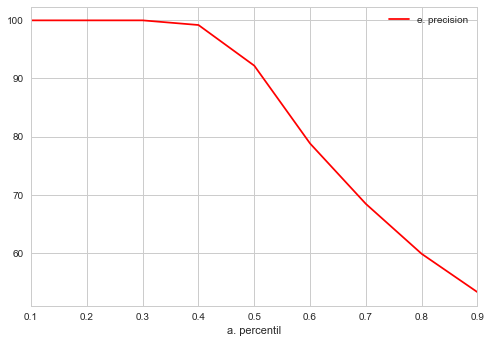

In [88]:
import matplotlib.pyplot as plt
import pandas as pd

# gca stands for 'get current axis'
#ax = plt.gca()
ax=ax
tab1.plot(kind='line',x= 'a. percentil' ,y= 'e. precision', color='red')
tab1.plot(kind='line',x= 'a. percentil',y=  'd. recall', color='blue', ax=ax)

plt.show()
